In [12]:
%%bash
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
technical_indicators_scaled_day = pd.read_csv('/content/drive/My Drive/technical_indicators_scaled_day.csv', index_col=0)
ticker_data_day = pd.read_csv('/content/drive/My Drive/ticker_data_day.csv', index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Define a function to label the data based on the fixed number of days (d)
def label_data_fixed_days(row_index, d, close_prices, binary=True):
    if row_index + d >= len(close_prices):
        return None
    current_price = close_prices.iloc[row_index]
    future_price = close_prices.iloc[row_index + d]
    if binary:
        return 1 if future_price > current_price else 0
    else:
        return 1 if future_price > current_price else -1

Fitting 5 folds for each of 10 candidates, totalling 50 fits
d = 1, Average accuracy: 0.5094505494505495
d = 2, Average accuracy: 0.5072527472527473
d = 3, Average accuracy: 0.5164835164835164
d = 4, Average accuracy: 0.5257142857142857
d = 5, Average accuracy: 0.49846153846153846
d = 6, Average accuracy: 0.5202643171806167
d = 7, Average accuracy: 0.460352422907489
d = 8, Average accuracy: 0.4753303964757709
d = 9, Average accuracy: 0.4493392070484581
d = 10, Average accuracy: 0.47004405286343615
d = 11, Average accuracy: 0.5290748898678415
d = 12, Average accuracy: 0.5262693156732892
d = 13, Average accuracy: 0.5262693156732892
d = 14, Average accuracy: 0.5430463576158939
d = 15, Average accuracy: 0.6141280353200882
d = 16, Average accuracy: 0.6181015452538631
d = 17, Average accuracy: 0.6295805739514349
d = 18, Average accuracy: 0.629646017699115
d = 19, Average accuracy: 0.6557522123893805
d = 20, Average accuracy: 0.654867256637168
d = 21, Average accuracy: 0.6867256637168142
d = 

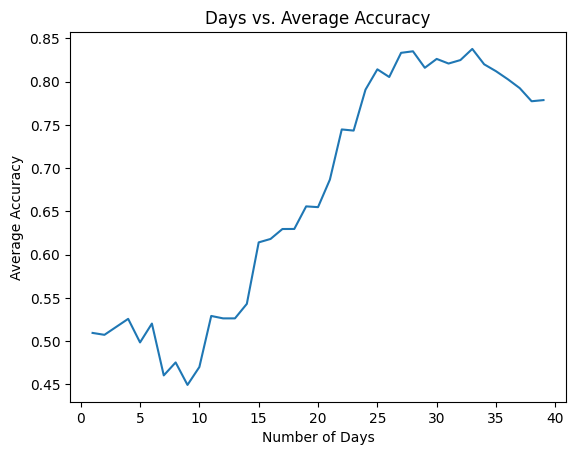

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Your specified parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 1000, 50),
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': np.arange(3, 10),
    'min_child_weight': np.arange(1, 6),
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6),
    'gamma': np.logspace(-3, 0, 10),
}

# Find the best hyperparameters using a dummy X and y
dummy_X = np.random.rand(100, 7)
dummy_y = np.random.randint(0, 2, 100)

random_search = RandomizedSearchCV(
    XGBClassifier(eval_metric="logloss"),
    param_distributions=param_dist,
    n_iter=10,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
)
random_search.fit(dummy_X, dummy_y)
best_params = random_search.best_params_

# Modify the original for loop to use the best hyperparameters
d_values = list(range(1, 40))  # Test different values of d
best_d, best_model, best_accuracy, best_report = None, None, 0, None
accuracy_results = []

for d in d_values:
    # Label the data using the current value of d
    technical_indicators_scaled_day['Label'] = 0
    for idx in range(len(technical_indicators_scaled_day)):
        binary_label = label_data_fixed_days(idx, d, ticker_data_day['Close'], binary=True)
        if binary_label is not None:
            technical_indicators_scaled_day.loc[technical_indicators_scaled_day.index[idx], 'Label'] = binary_label

    y = technical_indicators_scaled_day['Label'].values
    X = technical_indicators_scaled_day.drop(columns=['Label'])

    # Remove the last d rows
    X = X.iloc[:-d]
    y = y[:-d]

    k = 7  # Select the top k features
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_kbest = selector.fit_transform(X, y)

    # Define the XGBoost model
    model = XGBClassifier(eval_metric="logloss", **best_params)

    tscv = TimeSeriesSplit(n_splits=5)
    accuracy_scores = []
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in tscv.split(X_kbest):
        X_train, X_test = X_kbest[train_index], X_kbest[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred.flatten())

    # Calculate the average accuracy
    average_accuracy = np.mean(accuracy_scores)
    accuracy_results.append(average_accuracy)

    if average_accuracy > best_accuracy:
        best_d = d
        best_accuracy = average_accuracy
        best_model = model
        best_report = classification_report(y_true_all, y_pred_all)

    print(f"d = {d}, Average accuracy: {average_accuracy}")

print(f"Best d value: {best_d}, with average accuracy: {best_accuracy}")
print("\nClassification report:")
print(best_report)

# Plot the accuracy graph
plt.plot(d_values, accuracy_results)
plt.xlabel("Number of Days")
plt.ylabel("Average Accuracy")
plt.title("Days vs. Average Accuracy")
plt.show()
